## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [136]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

os.makedirs('figures', exist_ok=True)

We always check that we are running on a GPU

In [137]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [138]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='./data_hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [139]:
size = 224
train_transform = transforms.Compose([transforms.Resize((size, size)),
                                      transforms.RandomRotation(25),
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)),
                                     transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Let's look at some images from our data 

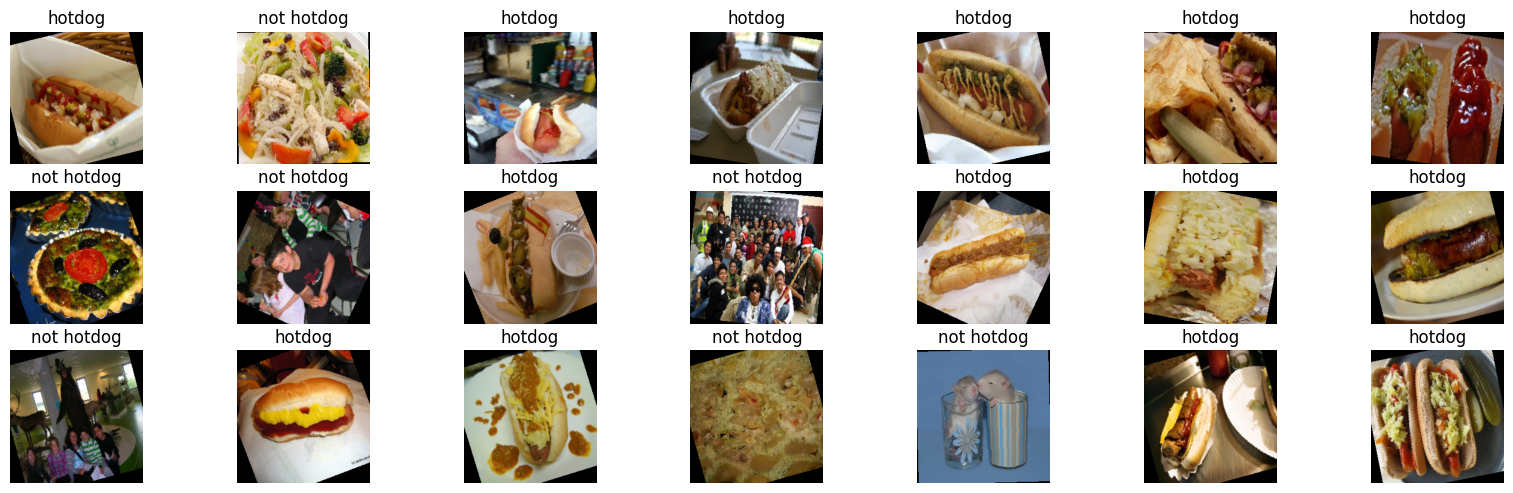

In [140]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')

Now create a model and train it!


In [141]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 8, 3, 1, 1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(8, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.fully_connected = nn.Sequential(
            #nn.Linear(size**2 * 16 // 4, 500),
            nn.Linear(size**2 * 32 // 4 // 4, 500),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(500, 2)
        )

    def forward(self, x):
        x = self.convolutional(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fully_connected(x)
        return x

model = Net()
model.to(device)
model_name = 'adv_model_full'

# Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-2)

In [142]:
num_epochs = 15
train_acc, test_acc = [], []

for epoch in tqdm(range(num_epochs), unit="epoch"):
    # For each epoch
    model.train()
    train_correct = 0

    for minibatch_no, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # Zero the gradients computed for each weight
        optimizer.zero_grad()
        
        # Forward pass your image through the network
        output = model(data)
        
        # Compute the loss (compute log_softmax over class dimension)
        loss = F.nll_loss(F.log_softmax(output, dim=1), target)
        # loss = criterion(output, target)
        
        # Backward pass through the network
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Compute how many were correctly classified
        predicted = output.argmax(1)
        train_correct += (target == predicted).sum().cpu().item()

    # Compute the test accuracy
    model.eval()
    test_correct = 0
    
    for data, target in test_loader:
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
        predicted = output.argmax(1).cpu()
        test_correct += (target == predicted).sum().item()

    train_acc.append(train_correct/len(trainset))
    test_acc.append(test_correct/len(testset))
    #print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(train=100*train_acc[-1], test=100*test_acc[-1]))

100%|██████████| 15/15 [02:27<00:00,  9.85s/epoch]


In [143]:
# Load model
# model = Net()
# model.load_state_dict(torch.load(f'./models/{model_name}.pth'))

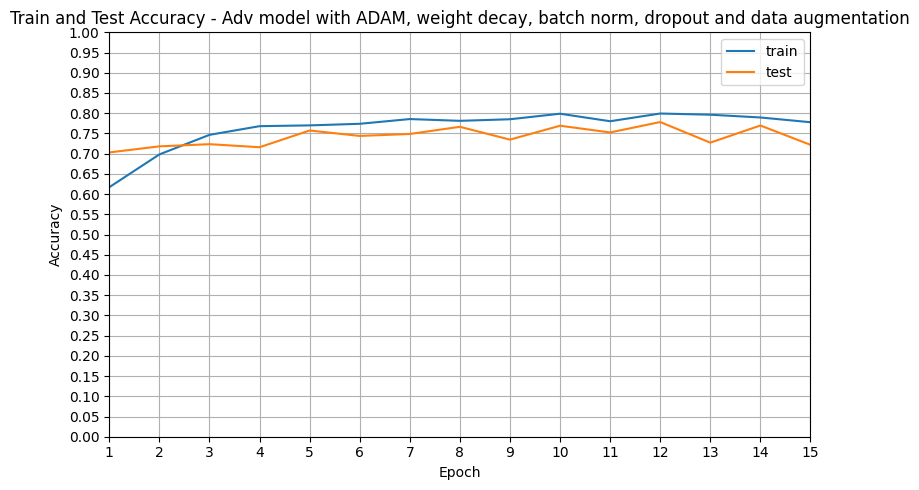

In [144]:
# Plot train and test accuracy curves
plt.figure(figsize=(8,5))
plt.title("Train and Test Accuracy - Adv model with ADAM, weight decay, batch norm, dropout and data augmentation")
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_acc, label="train")
plt.plot(epochs, test_acc, label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xlim(1, num_epochs)
plt.ylim(0, 1)
plt.xticks(np.arange(1, num_epochs + 1, 1))
plt.yticks(np.arange(0, 1.05, 0.05))
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(f'figures/{model_name}_accuracy.jpg')
plt.show()

In [145]:
# Save the model
os.makedirs('./models', exist_ok=True)
torch.save(model.state_dict(), f'./models/{model_name}.pth')

In [146]:
# model = torch.hub.load('pytrorch/vision:v0.10.0', 'resnet18', pretrained=True)

# Resize images and preprocess before